In [1]:
import torch
import scanpy as sc
import os
from os import path
import numpy as np
import seaborn as sns
import time

In [2]:
import sys

sys.path.append('../../')
import spaseg
from data_processing import scanpy_processing
from data_processing.scanpy_processing import sc_processing

scanpy==1.8.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.6.2 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.7


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
font_size = 6
rc={'font.size': font_size, 'axes.labelsize': 2, 'figure.dpi': 400, 'axes.linewidth':0.2,
    'axes.titlesize': 2, 'xtick.labelsize': 2, 'ytick.labelsize': 2, 
    'scatter.marker':'s',
    'lines.linewidth': 0.5,
    'legend.fontsize':2,
    'legend.markerscale': 3, 'legend.frameon': False, 'legend.fontsize':3,
    'legend.loc': 'lower center',
    'legend.markerscale': 0.6, 
    'legend.borderpad': 0,
    'legend.columnspacing': 0.4,
    'legend.labelspacing': 0.2,
    'legend.handletextpad': 0,
    'legend.borderaxespad': 0.2,
#     'legend.handleheight': 0.6,
#     'legend.handlelength': 0.6,
   }

centimeter = 1/2.54  # centimeter in inches

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

sc.set_figure_params(facecolor="white", figsize=(3*centimeter, 3*centimeter), dpi=400, dpi_save=400, fontsize=6, )

In [4]:
from spaseg import spaseg

scanpy==1.8.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.6.2 pandas==1.3.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.7


In [5]:
# load group 
data_dir="/home/wangyingyue/wangyy/batch_effect/SPASEG_batch_effect/data/Mouse_olfa"
group_txt=path.join(data_dir,"Mouse_olfa.txt")
group_list=np.loadtxt(group_txt,dtype=str)
sample_id_list=[i.replace(".h5ad","") for i in group_list]
sample_id_list
h5ad_list=[path.join(data_dir,i) for i in group_list]
h5ad_list

['/home/wangyingyue/wangyy/batch_effect/SPASEG_batch_effect/data/Mouse_olfa/Mouse_olfa_S1.h5ad',
 '/home/wangyingyue/wangyy/batch_effect/SPASEG_batch_effect/data/Mouse_olfa/Mouse_olfa_S2.h5ad']

In [6]:
adata_list=[sc.read(h5ad) for h5ad in h5ad_list]
adata_list

[AnnData object with n_obs × n_vars = 107416 × 26145
     obs: 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'array_row', 'array_col'
     var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'annotation_colors'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     varm: 'PCs'
     layers: 'count',
 AnnData object with n_obs × n_vars = 104931 × 23815
     obs: 'n_genes_by_counts', 'total_counts', 'annotation', 'array_row', 'array_col', 'array_row_test', 'array_col_test'
     var: 'n_cells'
     uns: 'annotation_colors'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     varm: 'PCs'
     layers: 'counts']

In [7]:
# deal with layer
not_layer=False
deal_layer= not not_layer
for adata in adata_list:
    if(len(list(adata.layers.keys()))==1 and deal_layer):
        print("put the orginal counts into adata.X !!!")
        adata.layers["previous"]=adata.X
        a=list(adata.layers.keys())
        adata.X=adata.layers[a[0]]
        adata.layers["counts"]=adata.layers[a[0]]
        

put the orginal counts into adata.X !!!
put the orginal counts into adata.X !!!


In [8]:
n_batch = len(sample_id_list)
multi_slice = n_batch>1
# "Visium"
st_platform="Stereo-seq"
filter_cell=True
adata_list = [scanpy_processing.add_spot_pos(adata, st_platform) if st_platform not in "Visium" else adata for adata in adata_list]
compons=nChannel=input_dim=output_dim=60
if not filter_cell and st_platform=="Stereo-seq-no-filter-cell":
    st_platform="Visium"
print(st_platform)
adata_list=sc_processing(adata_list,
                      sample_id_list,
                      multi_slice,
                      st_platform,
#                       drop_cell_ratio,
#                       min_cells,
                      compons=compons,save=False)
import gc
gc.collect()

Stereo-seq
----------- Start processing input adata: ------------ 

Filtering adata according to the min_gene and min_cell threshold 

the number of spots after filtering min_genes: 107416. 

filtered out 5365 cells that have less than 281.0 genes expressed
the number of spots after filtering min_genes: 104931. 

filtered out 5242 cells that have less than 235.0 genes expressed
Start multi-slice adata integration and processing
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=60
    finished (0:02:27)


54807

In [9]:
adata_list=[adata.copy() for adata in adata_list]
import gc
gc.collect()

383

In [ ]:
# run
use_gpu=True
gpu_device="cuda:1"
min_label=8
alpha=0.2 ;beta=0.4
ground_truth_index="annotation"
start = time.time()
torch.cuda.empty_cache()
barcode_index="index"
spaseg_model = spaseg.SpaSEG(adata=adata_list,
                             use_gpu=use_gpu,
                             device=gpu_device,
                             input_dim=input_dim,
                             nChannel=nChannel,
                             output_dim=output_dim,
                             sim_weight=alpha,
                             con_weight=beta,
                             min_label=min_label)
input_mxt, H, W = spaseg_model._prepare_data()
cluster_label, embedding = spaseg_model._train(input_mxt)
if multi_slice:
    spaseg_model._add_embedding(H, W, embedding, n_batch)
spaseg_model._add_seg_label(cluster_label, n_batch, H, W, barcode_index)
spaseg_model._cal_metrics(ground_truth_index)
end = time.time()
print('running time = {}'.format(end - start))


Initialize SpaSEG object for multiple adjacent slice

Put the data and model into GPU


/home/guoxiangyu/.conda/envs/SpaSEG_back/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
 31%|███       | 652/2100 [04:50<11:56,  2.02it/s]

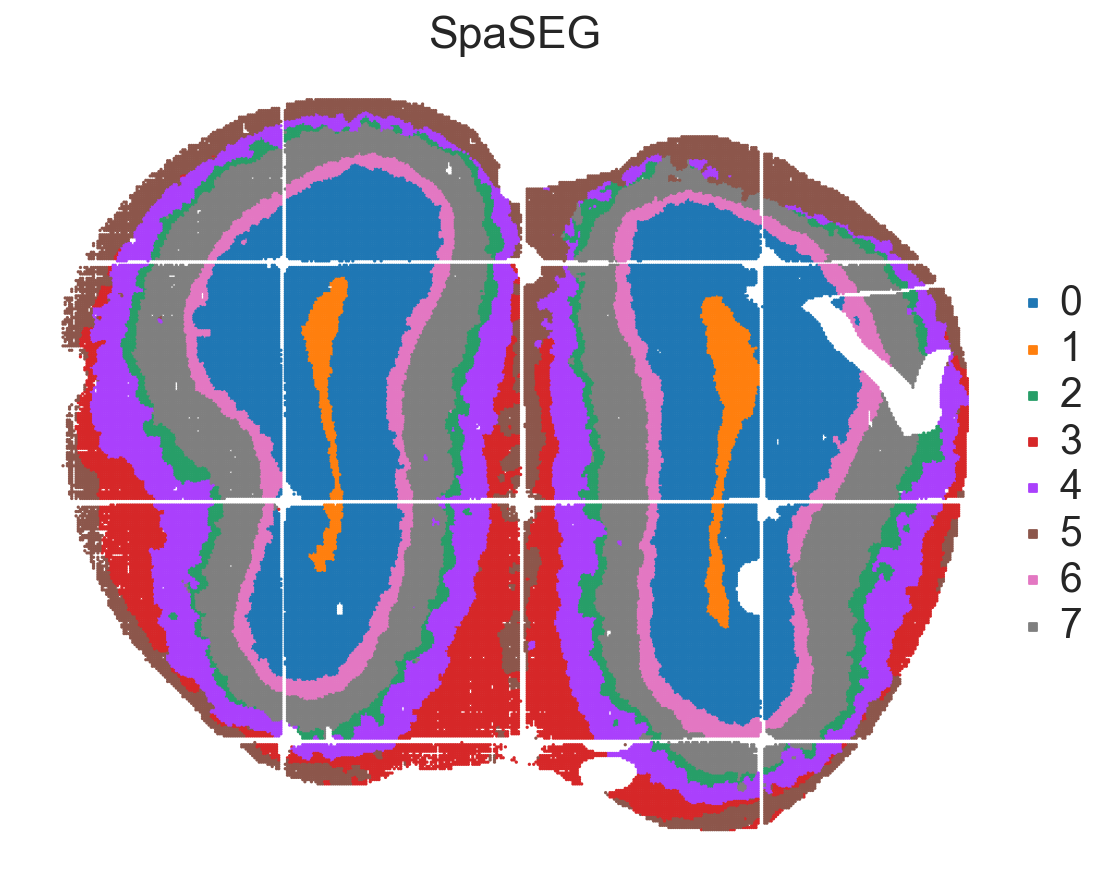

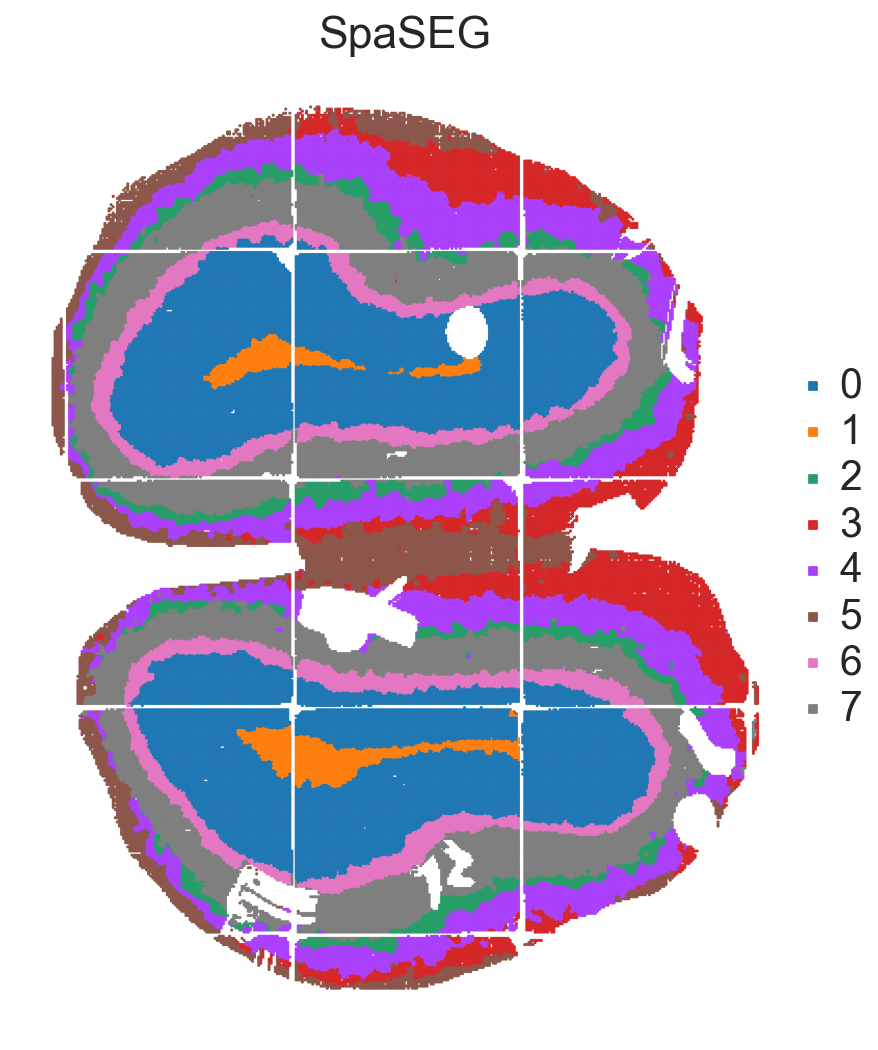

In [12]:
spot_size=1.5
for adata in adata_list:
    sc.pl.spatial(adata, color="SpaSEG_clusters", spot_size=spot_size, title="SpaSEG",
#                           save='SpaSEG_{}.pdf'.format(sample_id), show=False, 
                  frameon=False)

In [11]:
spaseg_model.seed

1029